In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.models import load_model
from keras.utils import Sequence
import keras.backend as K

Using TensorFlow backend.


In [ ]:
# Tensorflow settings
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, get_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "6"
sess = tf.Session(config=config)
set_session(sess)

In [3]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [4]:
def reset_weights(model):
    # Note this only used for visualization below
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [5]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense
from keras.regularizers import l2
def Normal_SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv3D(64, kernel_size=3, 
                     input_shape=(input_shape[1], input_shape[2], input_shape[3], 1), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling3D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_2', kernel_initializer='glorot_normal'))

    model.add(MaxPooling3D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay), kernel_initializer='glorot_normal'))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay), kernel_initializer='glorot_normal'))
    model.add(MaxPooling3D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    return model

In [6]:
use_normal_dist = True

In [7]:
# load model weights
model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_6.h5"
fine_tuned_weights = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial5-improvement-BEST.hdf5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

if use_normal_dist:
    model_untrained = Normal_SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=(None, 96, 114, 96))
else:
    model_untrained = load_model(model_path)
    reset_weights(model_untrained)

model_fine_tuned = load_model(model_path)
model_fine_tuned.load_weights(fine_tuned_weights)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

In [8]:
model_untrained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [9]:
def visualize_weights(model, layer=0, nrows=2, figsize=(20, 20)):
    # Visualize weights
    W = model.layers[layer].get_weights()[0]
    W = np.reshape(W, (W.shape[0], W.shape[1], W.shape[2], W.shape[3] * W.shape[4]))
    print(W.shape)
    W = W[:,:,2]
    print(W.shape)
    #W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=figsize)
    plt.title('layer {} weights'.format(layer))
    plt.imshow(make_mosaic(W, nrows=nrows), cmap="gray")
    plt.show()

In [10]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[-1]
    imshape = imgs.shape[:2]
    ncols = int(np.floor(nimgs / nrows))
    #print(ncols)
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    print(mosaic.shape)
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    row = 0
    for i in range(nimgs):
        #print("next")
        #print(i)
        row = int(np.floor(i / ncols))
        col = i % ncols
        #print(row * paddedh)
        #print(row * paddedh + imshape[0])
        #print(col * paddedw)
        #print(col * paddedw + imshape[1])
        #print(mosaic[row * paddedh:row * paddedh + imshape[0],
        #       col * paddedw:col * paddedw + imshape[1]].shape)
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,i]
    return mosaic

# Layer 0

Random model layer 1 weights:
(3, 3, 3, 64)
(3, 3, 64)
W shape :  (3, 3, 64)
Weights mean 0.0022247950546443462
(7, 127)


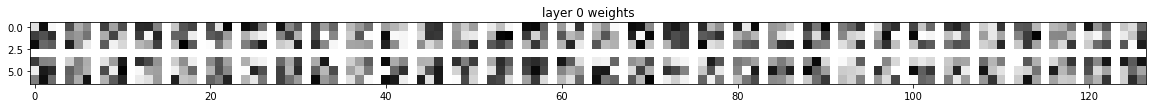

Pre-trained model layer 1 weights:
(3, 3, 3, 64)
(3, 3, 64)
W shape :  (3, 3, 64)
Weights mean -0.0010960017098113894
(7, 127)


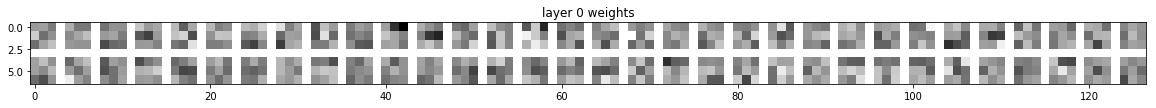

Fine-tuned model layer 1 weights:
(3, 3, 3, 64)
(3, 3, 64)
W shape :  (3, 3, 64)
Weights mean 0.005122987087816
(7, 127)


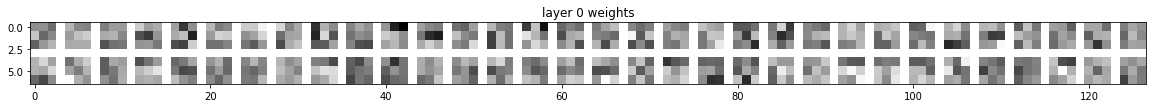

In [11]:
# Visualize weights
print("Random model layer 1 weights:")
visualize_weights(model_untrained, layer=0)
print("Pre-trained model layer 1 weights:")
visualize_weights(model, layer=0)
print("Fine-tuned model layer 1 weights:")
visualize_weights(model_fine_tuned, layer=0)

# Layer 3

Random model layer 3 weights:
(3, 3, 3, 4096)
(3, 3, 4096)
W shape :  (3, 3, 4096)
Weights mean 0.00022130372235551476
(255, 255)


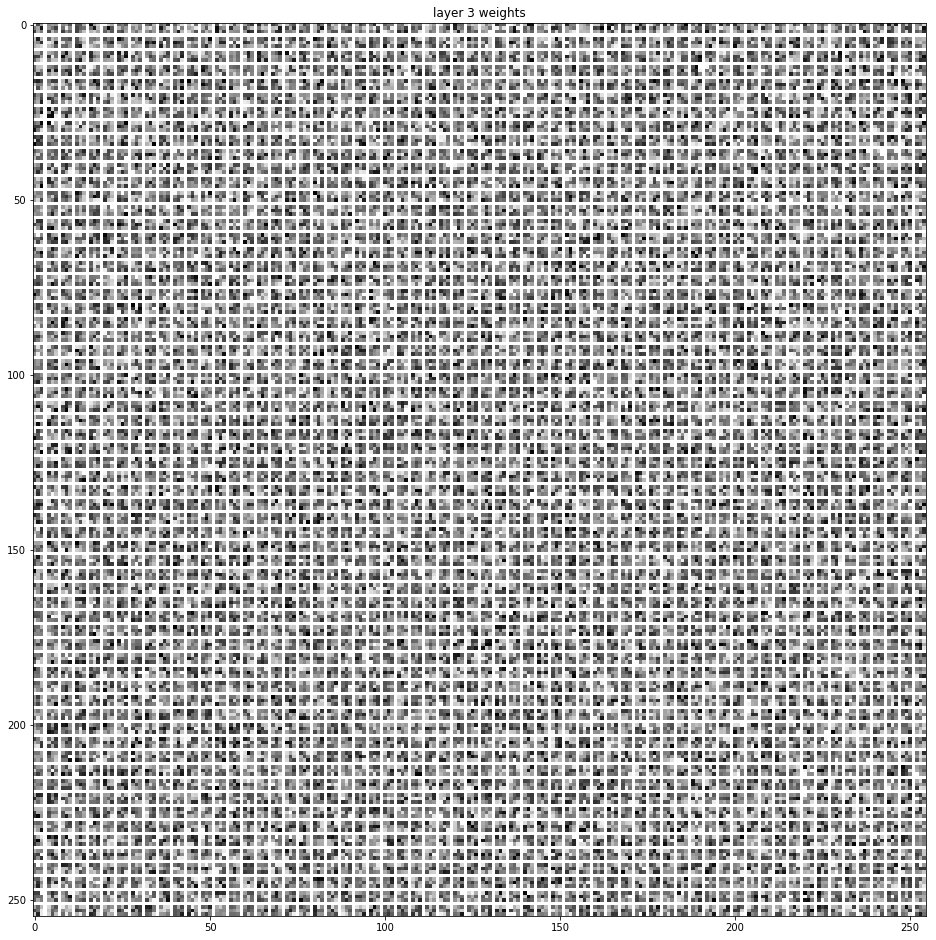

Pre-trained model layer 3 weights:
(3, 3, 3, 4096)
(3, 3, 4096)
W shape :  (3, 3, 4096)
Weights mean -0.00111997255589813
(255, 255)


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/image.py:419: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


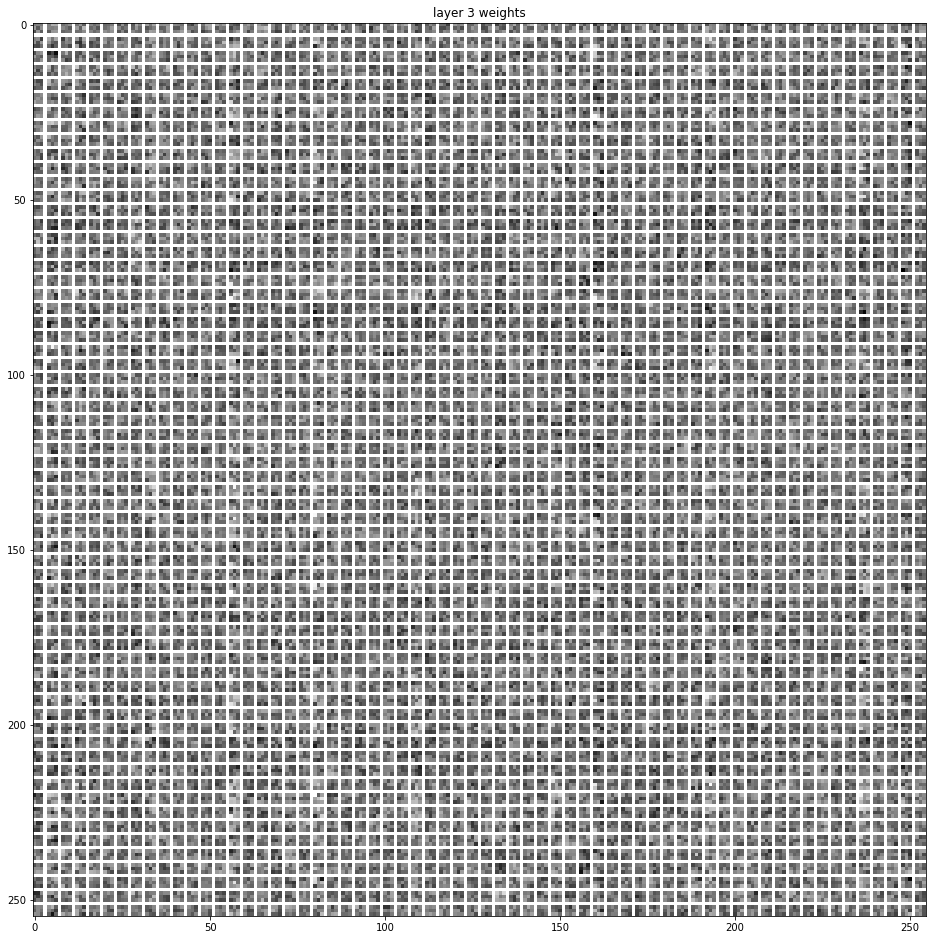

Fine-tuned model layer 3 weights:
(3, 3, 3, 4096)
(3, 3, 4096)
W shape :  (3, 3, 4096)
Weights mean 0.0005249119130894542
(255, 255)


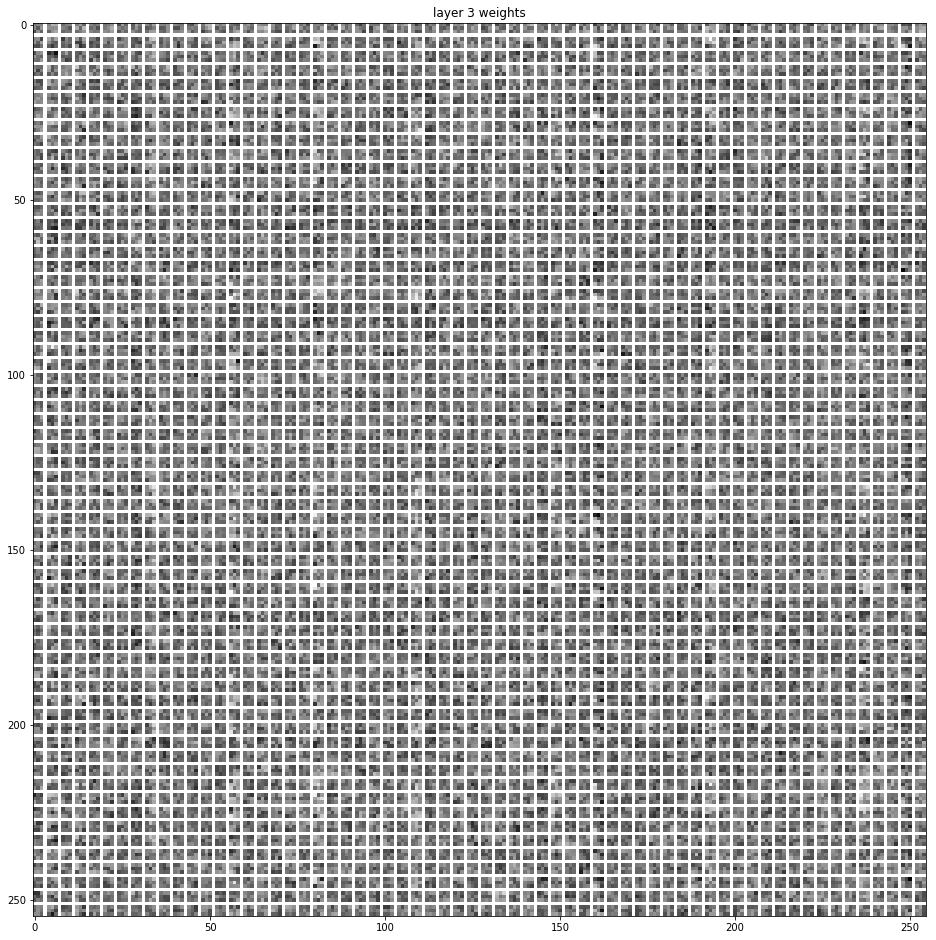

In [12]:
l = 3
# Visualize weights
print("Random model layer {} weights:".format(l))
visualize_weights(model_untrained, layer=l, nrows=64, figsize=(16, 32))
print("Pre-trained model layer {} weights:".format(l))
visualize_weights(model, layer=l, nrows=64, figsize=(16, 32))
print("Fine-tuned model layer {} weights:".format(l))
visualize_weights(model_fine_tuned, layer=l, nrows=64, figsize=(16, 32))

# Layer 6

Random model layer 6 weights:
(3, 3, 3, 4096)
(3, 3, 4096)
W shape :  (3, 3, 4096)
Weights mean -0.00014728376118000597
(255, 255)


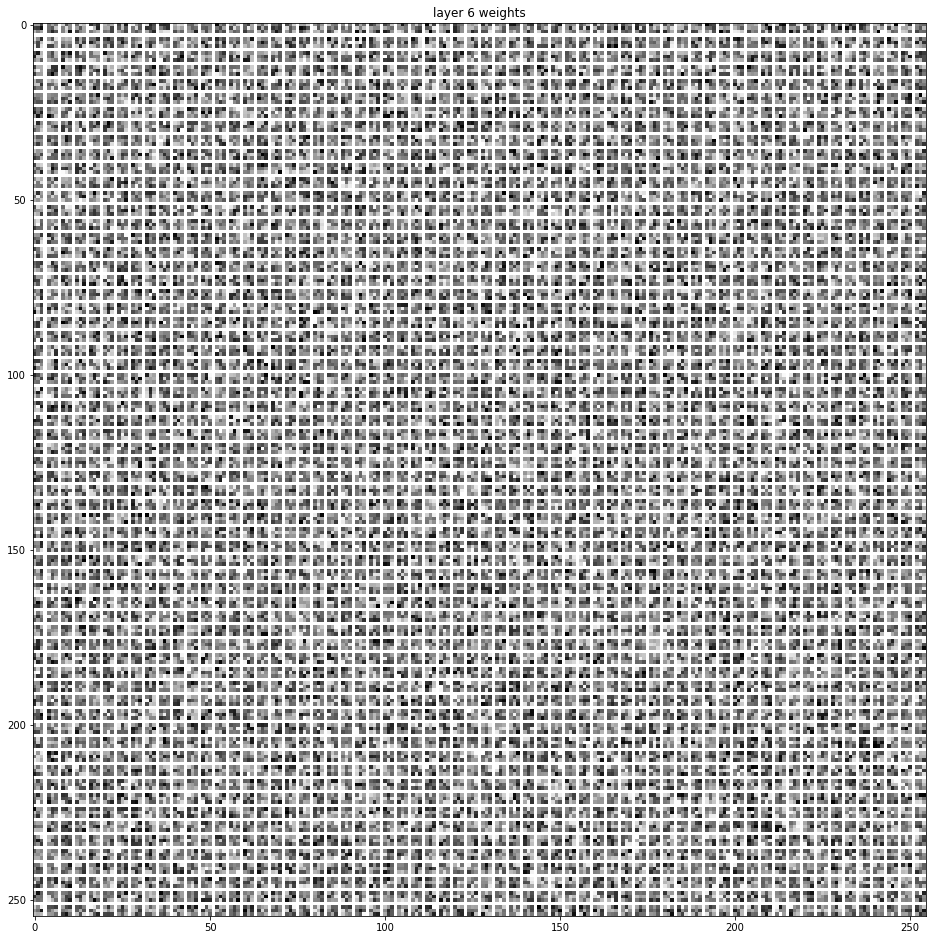

Pre-trained model layer 6 weights:
(3, 3, 3, 4096)
(3, 3, 4096)
W shape :  (3, 3, 4096)
Weights mean -8.52772718644701e-05
(255, 255)


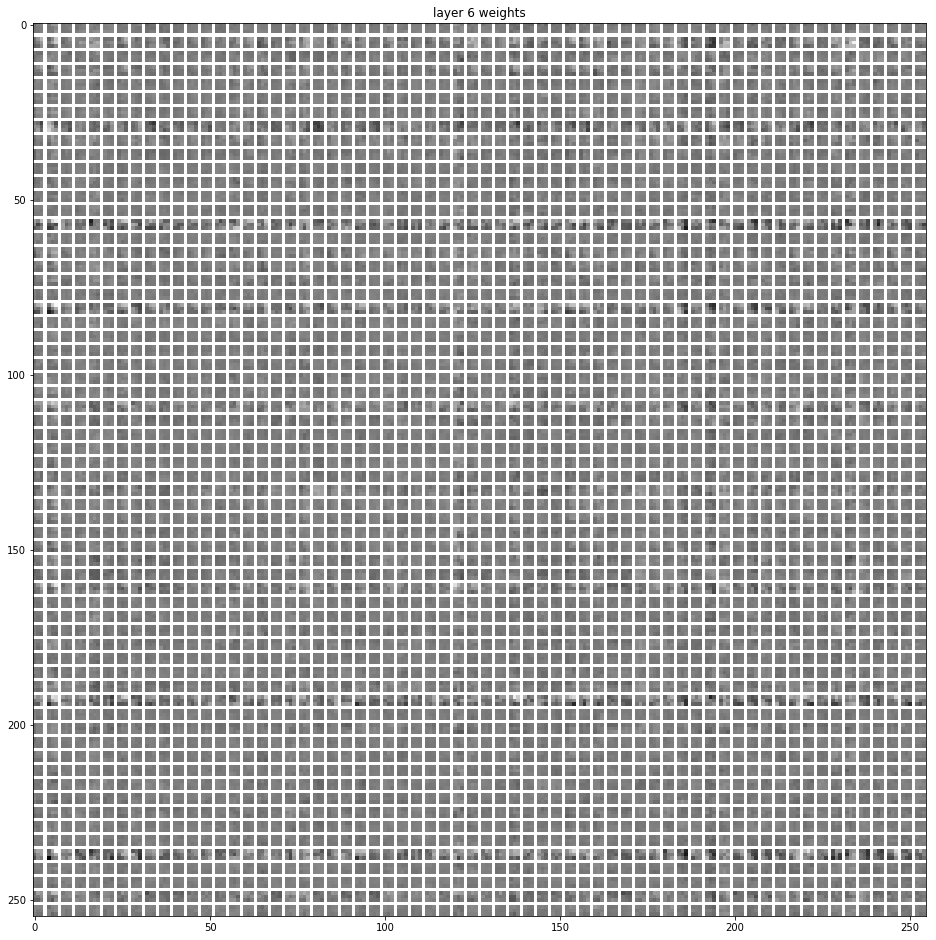

Fine-tuned model layer 6 weights:
(3, 3, 3, 4096)
(3, 3, 4096)
W shape :  (3, 3, 4096)
Weights mean 1.9593839169829153e-05
(255, 255)


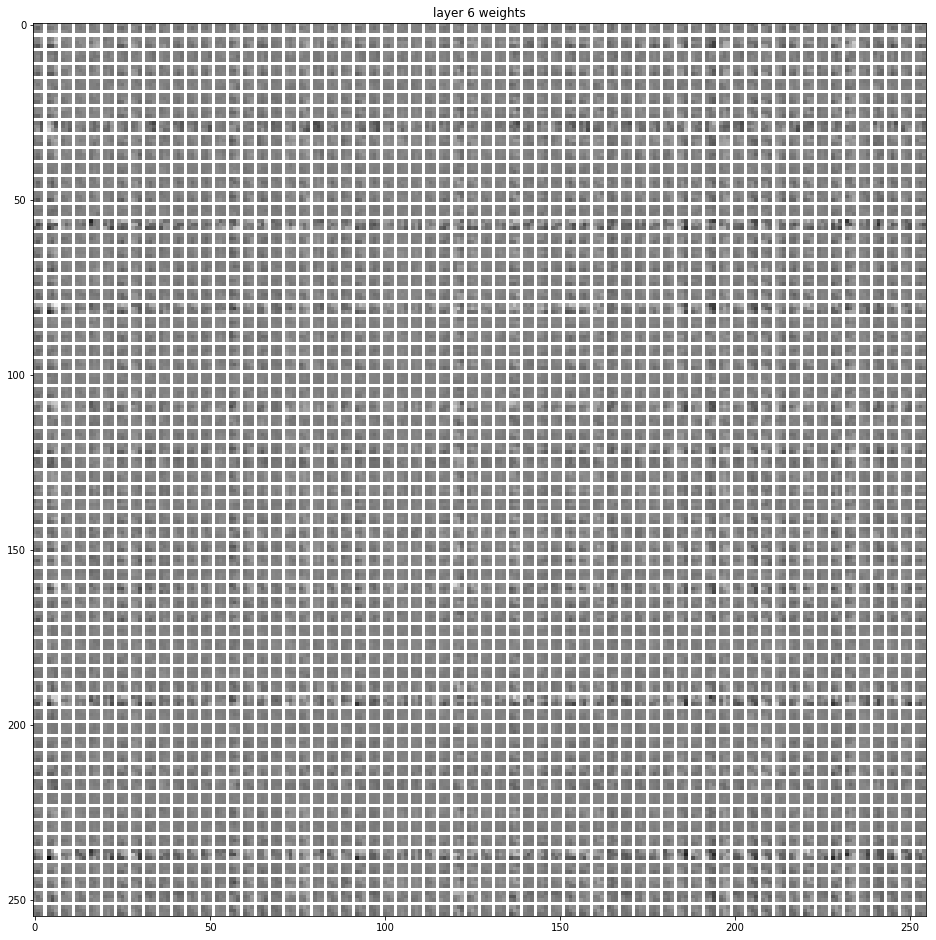

In [13]:
l = 6
# Visualize weights
print("Random model layer {} weights:".format(l))
visualize_weights(model_untrained, layer=l, nrows=64, figsize=(16, 32))
print("Pre-trained model layer {} weights:".format(l))
visualize_weights(model, layer=l, nrows=64, figsize=(16, 32))
print("Fine-tuned model layer {} weights:".format(l))
visualize_weights(model_fine_tuned, layer=l, nrows=64, figsize=(16, 32))

# Layer 7

Random model layer 7 weights:
(3, 3, 3, 4096)
(3, 3, 4096)
W shape :  (3, 3, 4096)
Weights mean 0.00024349434534087777
(255, 255)


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/image.py:412: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min
/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/colors.py:942: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


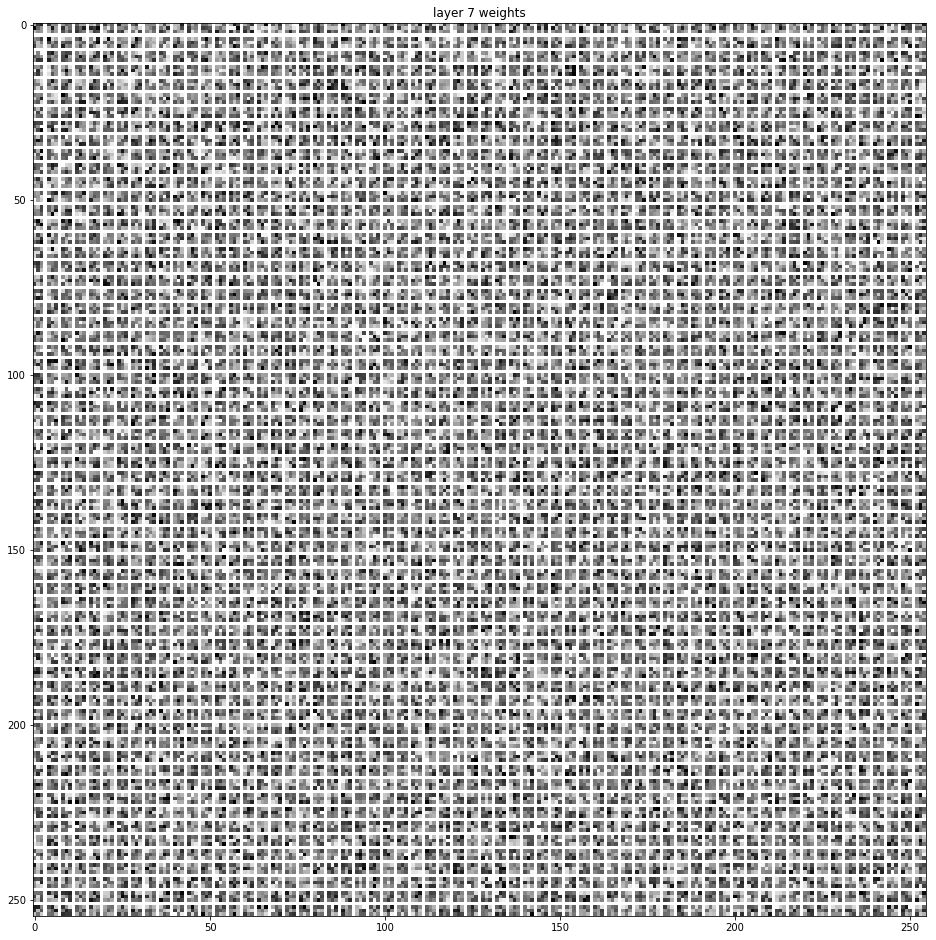

Pre-trained model layer 7 weights:
(3, 3, 3, 4096)
(3, 3, 4096)
W shape :  (3, 3, 4096)
Weights mean 0.0015273105818778276
(255, 255)


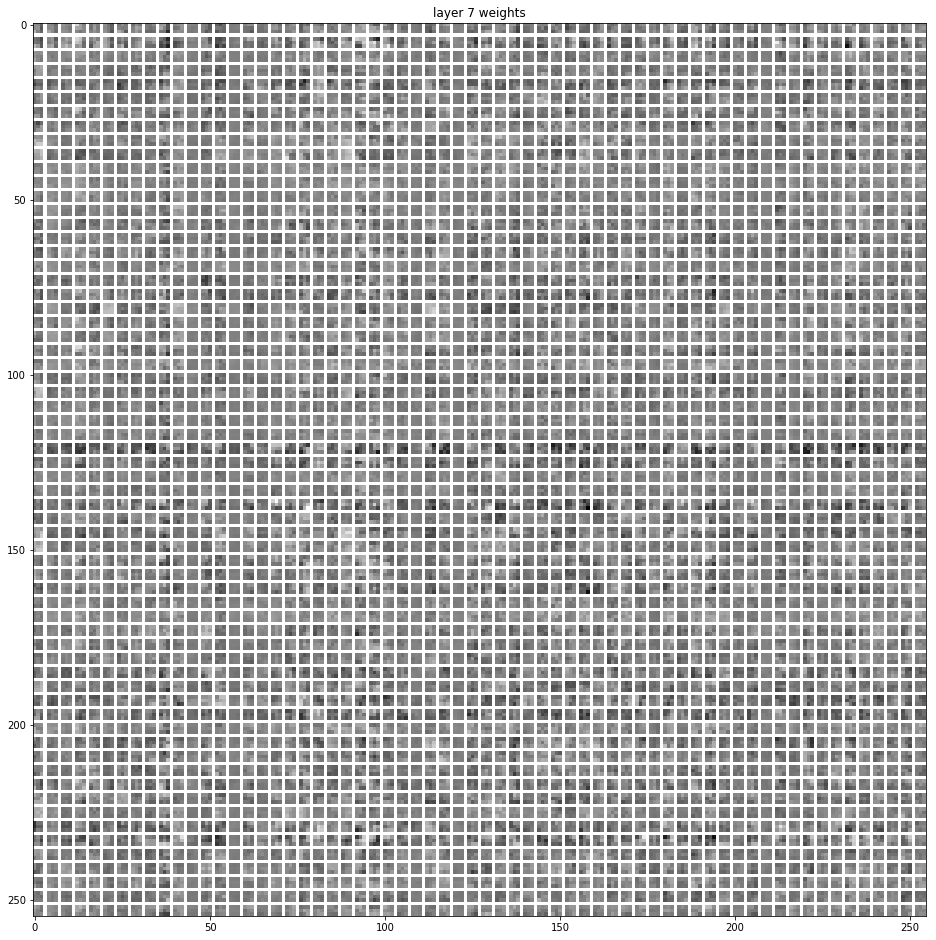

Fine-tuned model layer 7 weights:
(3, 3, 3, 4096)
(3, 3, 4096)
W shape :  (3, 3, 4096)
Weights mean 0.0010927743278443813
(255, 255)


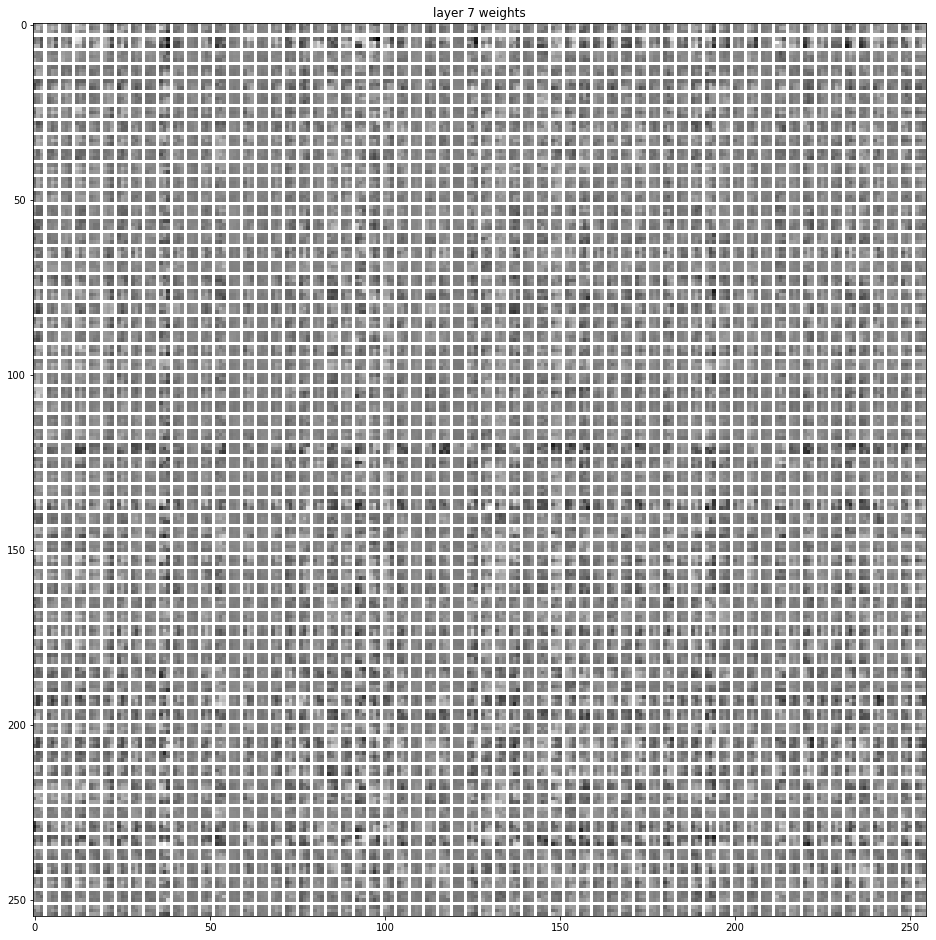

In [14]:
l = 7
# Visualize weights
print("Random model layer {} weights:".format(l))
visualize_weights(model_untrained, layer=l, nrows=64, figsize=(16, 32))
print("Pre-trained model layer {} weights:".format(l))
visualize_weights(model, layer=l, nrows=64, figsize=(16, 32))
print("Fine-tuned model layer {} weights:".format(l))
visualize_weights(model_fine_tuned, layer=l, nrows=64, figsize=(16, 32))

# Quantitative comparison

In [15]:
import seaborn as sns

/home/fabiane/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


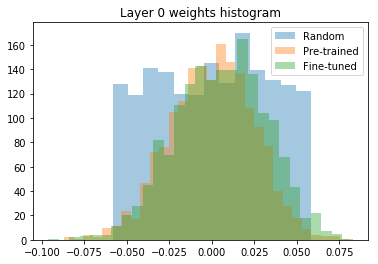

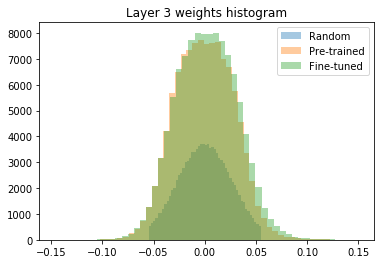

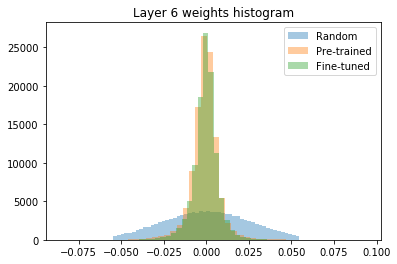

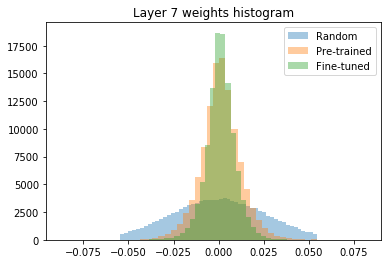

In [16]:
for layer in [0, 3, 6, 7]:
    sns.distplot(np.ravel(model_untrained.layers[layer].get_weights()[0]), hist=True, kde=False)
    sns.distplot(np.ravel(model.layers[layer].get_weights()[0]), hist=True, kde=False)
    sns.distplot(np.ravel(model_fine_tuned.layers[layer].get_weights()[0]), hist=True, kde=False)
    plt.legend(["Random", "Pre-trained", "Fine-tuned"])
    plt.title("Layer {} weights histogram".format(layer))
    plt.show()

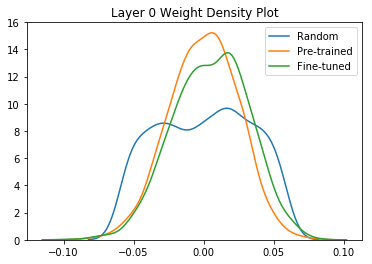

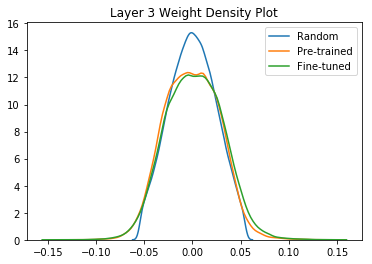

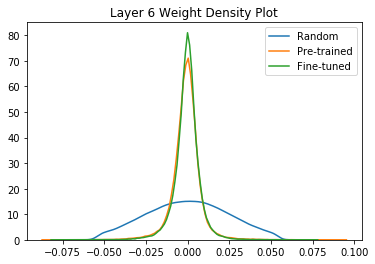

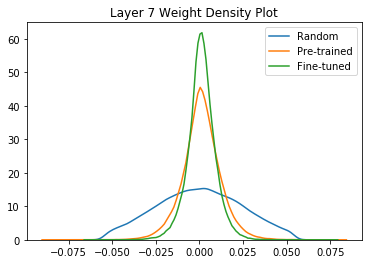

In [17]:
for layer in [0, 3, 6, 7]:
    sns.distplot(np.ravel(model_untrained.layers[layer].get_weights()[0]), hist=False, kde=True, label="Random")
    sns.distplot(np.ravel(model.layers[layer].get_weights()[0]), hist=False, kde=True, label="Pre-trained")
    sns.distplot(np.ravel(model_fine_tuned.layers[layer].get_weights()[0]), hist=False, kde=True, label="Fine-tuned")
    plt.title("Layer {} Weight Density Plot".format(layer))
    plt.show()

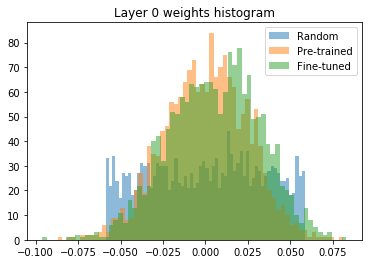

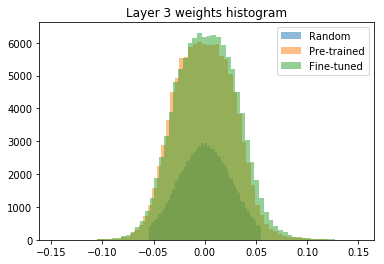

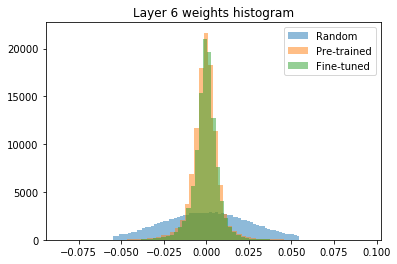

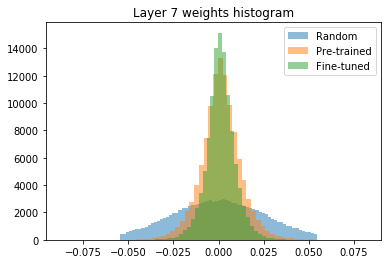

In [18]:
for layer in [0, 3, 6, 7]:
    plt.hist(np.ravel(model_untrained.layers[layer].get_weights()[0]), bins=64, alpha=0.5)
    plt.hist(np.ravel(model.layers[layer].get_weights()[0]), bins=64, alpha=0.5)
    plt.hist(np.ravel(model_fine_tuned.layers[layer].get_weights()[0]), bins=64, alpha=0.5)
    plt.legend(["Random", "Pre-trained", "Fine-tuned"])
    plt.title("Layer {} weights histogram".format(layer))
    plt.show()